# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Цель спрогнозировать, где бурить новую скважину. 

Задача постройть модель для определения региона, где добыча принесёт наибольшую прибыль.

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).


## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import numpy as np
from numpy.random import RandomState
state = RandomState(12345)

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df0.shape

(100000, 5)

In [4]:
df1.shape

(100000, 5)

In [5]:
df2.shape

(100000, 5)

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
print(df0.isnull().sum())
print(df1.isnull().sum())
print(df2.isnull().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [10]:
print(df0.duplicated().sum())
print(df1.duplicated().sum())
print(df2.duplicated().sum())

0
0
0


In [11]:
display(df0.nunique())
display(df1.nunique())
display(df2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Нет пропусков и дубликатов

<AxesSubplot:>

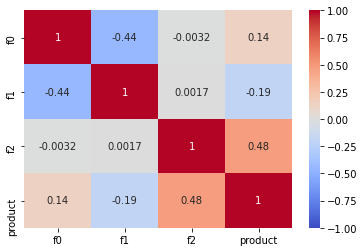

In [12]:
sns.heatmap(df0.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

<AxesSubplot:>

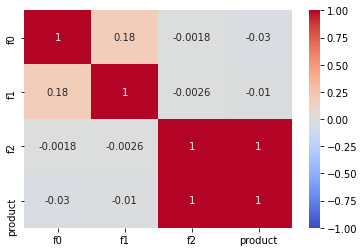

In [13]:
sns.heatmap(df1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

<AxesSubplot:>

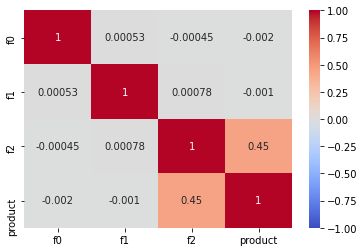

In [14]:
sns.heatmap(df2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

## Обучение и проверка модели

In [15]:
rmse_list = []
predictions_list = []
score_list = []
target = []
predictions_df = pd.DataFrame()
target_df = pd.DataFrame()

for i,j in zip([df0,df1,df2],range(3)):
    X = i.drop(['product','id'], axis=1)
    y = i['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=12345, test_size=0.25) 
    
    lr = LinearRegression(n_jobs = -1)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_valid)
    rmse = np.sqrt(np.mean((y_valid-predictions)**2))
    rmse_list.append(rmse)
    predictions_list.append(predictions.mean())
    score_list.append(lr.score(X_train,y_train))
    target.append(i['product'].mean())
    target_df[j] = y_valid
    predictions_df[j] = predictions

In [16]:
target_df = target_df.reset_index(drop=True)
scorelist = pd.DataFrame(
    data=[rmse_list, score_list, predictions_list, target], 
    index=['RMSE','SCORE','PREDICTED MEAN', 'TARGET MEAN'], 
    columns=['region 1','region 2','region 3'])
scorelist

,region 1,region 2,region 3
RMSE,37.579422,0.893099,40.029709
SCORE,0.274239,0.999625,0.196614
PREDICTED MEAN,92.592568,68.728547,94.965046
TARGET MEAN,92.500000,68.825000,95.000000


Модели 1 и 2 региона показывают плохие результаты. Эти регионы не подходят для скаважины.

Модель 2 региона показыла очень хорошие результаты, но у цели всего лишь 12 значений из 100 000 для модели было легко спрогнозировать правильные ответ. Поэтому 2 модель опасно использовать.

Предсказанное среднее и target среднее почти одинаково

## Подготовка к расчёту прибыли

In [17]:
budget = 10e9
total_reconnaissance = 500
profit_wells = 200
profit_from_one_barrel = 450
profit_from_one_product = 450000

цена за одну скаважину

In [18]:
well_drilling_price = budget / profit_wells
well_drilling_price

50000000.0

обьем сырья за одну скаважину без потерь

In [19]:
min_product_mean  = well_drilling_price/profit_from_one_product
min_product_mean

111.11111111111111

In [20]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (profit_from_one_product * selected.sum() - (budget))

In [21]:
print('Прибыль первого региона : {:.2f} млрд рублей'.format(revenue(target_df[0], predictions_df[0],200)/10**9))
print('Прибыль второго региона : {:.2f} млрд рублей'.format(revenue(target_df[1], predictions_df[1],200)/10**9))
print('Прибыль третьего региона :{:.2f} млрд рублей'.format(revenue(target_df[2], predictions_df[2],200)/10**9))

Прибыль первого региона : 3.32 млрд рублей
Прибыль второго региона : 2.42 млрд рублей
Прибыль третьего региона :2.71 млрд рублей


Минимальный объем в каждой скважине должен составлять 111 тыс барелей. Средние предсказания и средние target трех регионов не проходят минимальный порог

## Расчёт прибыли и рисков 

In [22]:
revenues = []

for i in range(1000):
    target_subsample = target_df[0].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[0][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
final_revenues = []
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 1', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.4259385269105924
2.5%-квантиль: -0.10209009483793653
Риск: 6.0
95% доверительный интервал:  (-102090094.83793654, 947976353.3583689)


In [23]:
revenues = []

for i in range(1000):
    target_subsample = target_df[1].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[1][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 2', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.5182594936973248
2.5%-квантиль: 0.12812323143308443
Риск: 0.3
Риск: 0.3 %
95% доверительный интервал:  (128123231.43308444, 953612982.0669085)


In [24]:
revenues = []

for i in range(1000):
    target_subsample = target_df[2].sample(n=500, replace=True, random_state=state)
    probs_subsample = predictions_df[2][target_subsample.index]
    revenues.append(revenue(target_subsample, probs_subsample, 200))

revenues = pd.Series(revenues)
lower = revenues.quantile(0.025)
mean = revenues.mean()
risks = (revenues < 0).mean()* 100
print("Средняя прибыль:", mean/10**9)
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (revenues.quantile(0.025), revenues.quantile(0.975))
print("Риск:", (revenues < 0).mean()* 100, '%')
print('95% доверительный интервал: ', confidence_interval)
final_revenues.append(('region 2', mean/10**9, lower/10**9, confidence_interval, risks))

Средняя прибыль: 0.4201940053440501
2.5%-квантиль: -0.11585260916001143
Риск: 6.2
Риск: 6.2 %
95% доверительный интервал:  (-115852609.16001143, 989629939.8445739)


Вывод

Регион 2 показывает лучшие результаты, но там всего 12 значений.

Лучше всего подоходит 1 регион. Из всех регионов бурить стоит там. Но в регионе 2 больше шанс получить прибыль

# Общий вывод:

Есть 3 датасета это три разных региона для прогнозирования объема сырья и прибыли. У датасетов не было никаких дубликатов, пустых значений. Во втором датасете только 12 уникальных значений. 

Исходя из всех результатов моделей мы получили такие результаты:

Регион 1: RMSE : 37.5 ; Score 0.27

Регион 2: RMSE : 0.89 ; Score 0.99

Регион 3: RMSE : 40.02 ; Score 0.19

Минимальный объем сырья должен составлять 111 тыс барелей. Средние показатели трех регионов не доходят до минимального порога.

Лучше всего добывать во 2 регионе



## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован